# Assignement - Statistical Arbitrage

- Alexandre KERHEEM
- Nicolas HESS
- Paul DE PELLEGARS-MALHORTIE

In [1]:
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA as PCA
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import calinski_harabasz_score as score_ch
from sklearn.metrics import davies_bouldin_score as score_db
from sklearn.metrics import silhouette_score as score_sc
from GapStat import gap_stat
import datetime as dt
import numpy as np
import pandas as pd

### STEP 1: Data Pre-processing

In [2]:
ALL_STOCKS_=pd.read_excel('Statistical Arbitrage Project DATA(2) (1) - Copie.xlsx' )
ALL_STOCKS=np.array(ALL_STOCKS_)
DATES = ALL_STOCKS[:,0]
ALL_STOCKS = ALL_STOCKS[:,1:]
dates = pd.DataFrame(index =DATES)

In [3]:
ALL_STOCKS = ALL_STOCKS.astype(float)
select=(1-np.sum(np.isnan(ALL_STOCKS),axis=0)==1)
STOCKS_SELECT=ALL_STOCKS[:,select]
select_id=np.arange(0,ALL_STOCKS.shape[1],1)[select]
n_stocks=STOCKS_SELECT.shape[1]

In [4]:
RETURNS=STOCKS_SELECT[1:,:]/STOCKS_SELECT[:-1,:]-1
RETURNS_NORM=preprocessing.scale(RETURNS)
n_obs=len(RETURNS)

In [5]:
start_calibration = "2015-01-01"
end_calibration = "2019-12-31"
start_oos = "2020-01-01"
end_oos = "2024-12-31"

### STEP 2: Hierarchical Clustering

## PCA of the covariance matrix

In [6]:
def get_pca(data, N_FACTORS = 5): 
    out_pca = PCA(data)
    share_variance=out_pca.eigenvals[:20]/sum(out_pca.eigenvals)
    share_variance_cumulated=np.cumsum(share_variance)
    FACTORS = preprocessing.scale((out_pca.factors)[:, 0:N_FACTORS])
    return out_pca, share_variance, share_variance_cumulated, FACTORS

def get_gapStat(data, clustering, DIST_1,cmax=30): 
    N_CLUSTER=0
    GAP_OUT=np.zeros((cmax-1,2))
    for i in np.arange(2,cmax+1,1):
        clusters=fcluster(clustering,i,criterion='maxclust')
        out=gap_stat('euclidean', 'ward', data.T, DIST_1, clusters, 50)
        GAP_OUT[i-2,:]=[out[0],out[1]]
    std_GAP=np.mean(out[1])
    for i in np.arange(2,cmax,1):
        if GAP_OUT[i-2,0]>(GAP_OUT[i-1,0]-GAP_OUT[i-1,1]):
            N_CLUSTER=i
            break
    plt.figure(figsize=(20, 10))
    plt.errorbar(np.arange(2,cmax+1,1), GAP_OUT[:,0], GAP_OUT[i-1,1], capsize=2, fmt='.')
    plt.title("Gap statistic +/- 1 standard deviation - %i clusters" %N_CLUSTER)
    plt.xticks(np.arange(2,cmax+1,1))
    plt.plot()
    return GAP_OUT,N_CLUSTER 

def get_eigen_ptf(clusters, data, N_CLUSTER):
    for i in range(1, N_CLUSTER+1):
        indices = np.where(clusters == i)[0]
        factor_cluster = data[indices,:]
        pca_clusters = PCA(factor_cluster)
        first_eigen_portfolio = pca_clusters.loadings[:, 0] 
    return pca_clusters, first_eigen_portfolio


5 factors retreiving 80 percent of the global variance


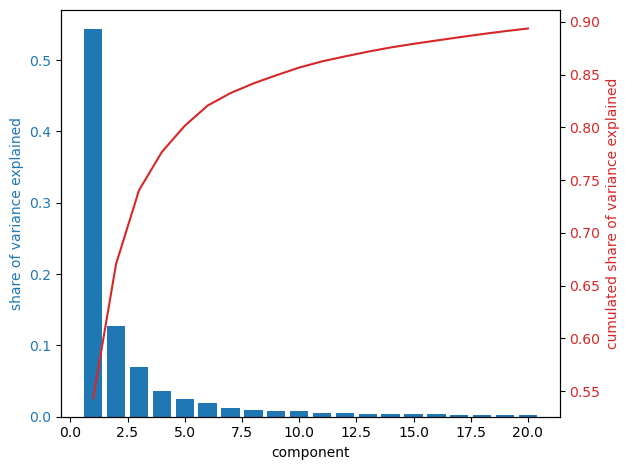

In [7]:
N_FACTORS = 5
index_end_calibration = dates.index.get_loc(end_calibration)
cov_matrix = np.cov(RETURNS_NORM[:index_end_calibration], rowvar=False)

out_pca, share_variance, share_variance_cumulated, FACTORS = get_pca(cov_matrix, N_FACTORS = 5)

print('%i factors retreiving ' %(N_FACTORS)+ '%i percent of the global variance' %(share_variance_cumulated[N_FACTORS-1]*100))

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('component')
ax1.set_ylabel('share of variance explained', color=color)
ax1.bar(np.arange(1,21,1), share_variance, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cumulated share of variance explained', color=color)
ax2.plot(np.arange(1,21,1), share_variance_cumulated, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

### Hierarchical Clustering

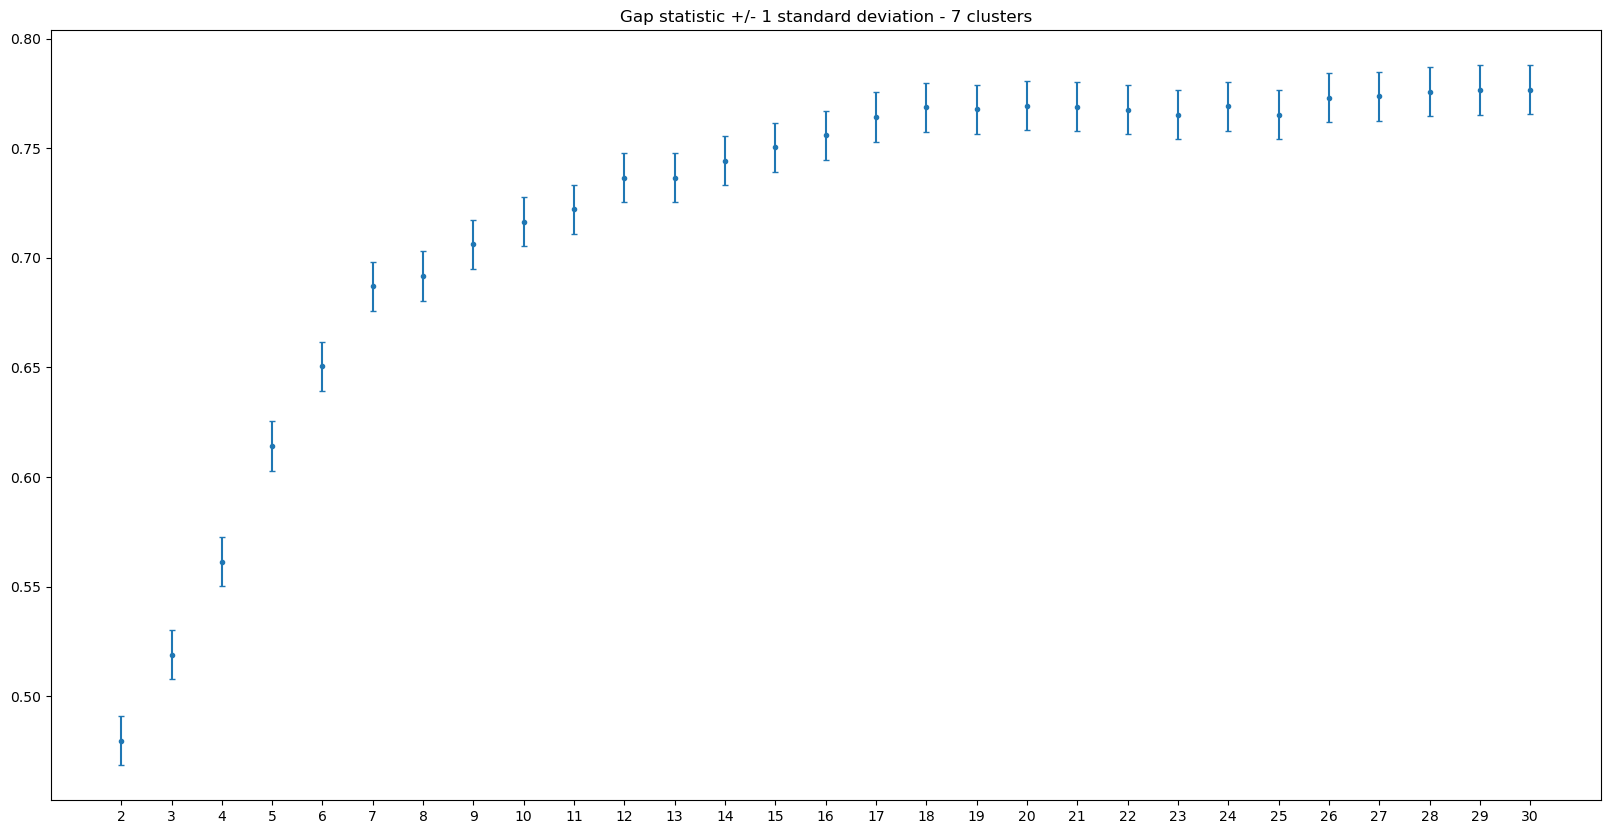

In [8]:
DIST_1 = pdist(FACTORS, 'euclidean')
clustering = linkage(DIST_1,method='ward')

cmax = 30 
GAP_OUT,N_CLUSTER = get_gapStat(FACTORS, clustering, DIST_1,cmax)

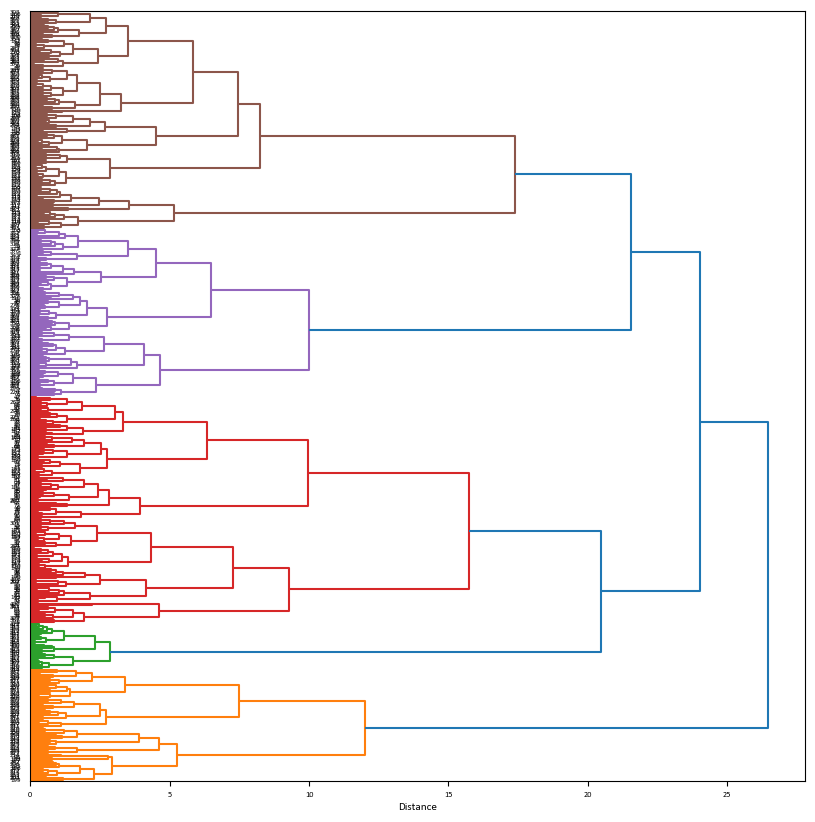

In [9]:
plt.figure(figsize=(10, 10))
csfont = {'fontname':'Calibri', 'fontsize' : '10'}
csfont2 = {'fontname':'Calibri', 'fontsize' : '8'}
csfont3 = {'fontname':'Calibri', 'fontsize' : '6'}
plt.xlabel('Distance',**csfont2)
plt.xticks(**csfont3)
plt.yticks(**csfont3)
dendrogram(clustering,truncate_mode='level',orientation='right',leaf_font_size=5)
plt.savefig('books_read.jpeg',bbox_inches='tight', dpi=300)
plt.show()

In [10]:
clusters = fcluster(clustering, N_CLUSTER, criterion='maxclust')
pca_clusters, first_eigen_portfolio = get_eigen_ptf(clusters, FACTORS, N_CLUSTER)

### STEP 4 Spread estimation (eigen-ptf computed within the spread estimation)

In [11]:
months_oos = np.arange(1,13)
year_oos = np.arange(2020,2025)
estimation_window = []

In [12]:
def get_number_of_days(dates, year, month):
    nbr_of_days = 0 
    for date in dates.index:
        if date.year == year and date.month == month: 
            nbr_of_days += 1
    return nbr_of_days

def get_last_trading_day_index(index_pd, dates): 
    estimation_index = []
    for last_index in index_pd:
       if last_index in dates.index:
            index = dates.index.get_loc(last_index)
            estimation_index.append(index)
       else:
           while last_index not in dates.index:
                last_index -= dt.timedelta(days=1)
           index = dates.index.get_loc(last_index)
           estimation_index.append(index)
    return estimation_index
    

##### Number of days per month

In [13]:
last_date = dates.index[-1]
last_year = last_date.year
last_month = last_date.month
index_pd = []

for year in year_oos:
    for month in months_oos:
        index_pm = dt.datetime(year, month, 1) - dt.timedelta(days=1)
        index_pd.append(index_pm)
        if year > last_year or (year == last_year and month > last_month):
            break
        nbr_days_one_month = get_number_of_days(dates, year, month)
        estimation_window.append(nbr_days_one_month)

estimation_index = get_last_trading_day_index(index_pd, dates)

#### Estimate spread and forecats

In [14]:
def get_params(main_portfolio_returns_cluster,returns_window, index_stck, i ): 
    model = sm.OLS(returns_window, sm.add_constant(main_portfolio_returns_cluster)).fit()
    a_estim = model.params[0]
    if len(model.params) > 1:
        b_estim = model.params[1]
    residuals = model.resid
    return a_estim,b_estim ,residuals, len(model.resid)
    
def eig_ptf(i, clusters, data): 
    indices = np.where(clusters == i)[0]
    factor_cluster = data[indices,:]
    pca_clusters = PCA(factor_cluster)
    first_eigen_portfolio = pca_clusters.loadings[:, 0] 
    return pca_clusters, first_eigen_portfolio, indices

def dates_idx(estimation_index, month): 
    start = estimation_index[i] - month + 1
    end = estimation_index[i] + 1
    start_forecast = estimation_index[i] + 1
    end_forecast = estimation_index[i] + month + 1
    return start, end, start_forecast, end_forecast

def get_actual_returns(RETURNS_NORM, start, end,start_forecast, end_forecast, stock_idx, first_eigen_ptf, B_RETURNS  ): 
    returns_estim = RETURNS_NORM[start:end, index_stck] 
    first_eigen_ptf_ret = B_RETURNS[start:end, :].dot(first_eigen_ptf)
    returns_estim_forecast = RETURNS_NORM[start_forecast:end_forecast, index_stck]
    first_eig_forecast = B_RETURNS[start_forecast:end_forecast, :].dot(first_eigen_ptf)
    
    return returns_estim, first_eigen_ptf_ret, returns_estim_forecast, first_eig_forecast


In [15]:
all_resid = []
B_RETURNS = RETURNS.dot(FACTORS)  
a_hat = np.zeros((len(estimation_window), n_stocks))
b_hat = np.zeros((len(estimation_window), n_stocks))
spread_fcst = np.zeros((len(estimation_window), n_stocks))


for i, month in enumerate(estimation_window):
    residuals = np.zeros((month, n_stocks))
    
    for cluster_indice in range(1, N_CLUSTER + 1):
        pca_cluster, first_eigen_ptf, cluster_indices = eig_ptf(cluster_indice,clusters,FACTORS)
        for index_stck in cluster_indices:
            start, end, start_forecast, end_forecast = dates_idx(estimation_index, month)
            if start < 0:
                continue
            returns_estim, first_eigen_ptf_ret, returns_estim_forecast, first_eig_forecast = get_actual_returns(RETURNS_NORM, start, end,start_forecast, end_forecast, index_stck, first_eigen_ptf, B_RETURNS) 
            if len(first_eigen_ptf_ret) != len(returns_estim):
                continue
            
            a_estim, b_estim ,residual, len_model = get_params(first_eigen_ptf_ret,returns_estim, index_stck, i )
            a_hat[i, index_stck] = a_estim
            b_hat[i, index_stck] = b_estim 
            residuals[:len_model, index_stck] = residual
            
            forecasted_residuals = returns_estim_forecast - (a_hat[i, index_stck] + b_hat[i, index_stck] * first_eig_forecast)
            spread_fcst[i, index_stck] = np.sum(forecasted_residuals)
    all_resid.append(residuals)
    

#### Build trading signals

In [16]:
def get_signal(SPREADp,thresholds):
    ShortStop = thresholds[0]
    ShortOpen = thresholds[1]
    ShortClose = thresholds[2]
    LongClose = thresholds[3]
    LongOpen = thresholds[4]
    LongStop = thresholds[5]
    n_periods, n_stocks = SPREADp.shape

    st = np.zeros((n_periods, n_stocks))
    lg = np.zeros((n_periods, n_stocks))

    for stock in range(n_stocks):
        for month in range(n_periods - 1):
            spread_t = SPREADp[month, stock]
            if ShortStop > spread_t > ShortOpen:
                st[month, stock] = -1 
            elif spread_t > ShortStop or spread_t < ShortClose:
                st[month, stock] = 1  
            if LongOpen < spread_t < LongStop:
                lg[month, stock] = 1  
            elif spread_t < LongStop or spread_t > LongClose:
                lg[month, stock] = -1 

    return st, lg

#### Compute Strategy

In [17]:
length_estimation_window = [252, 504, 126]
thresholds1 =np.array([2.5, 1.5, 0.5, -0.5, -1.5, -2.5])
thresholds2 =np.array([ 2, 1, 0.1, -0.1, -1, -2])
strat_setup1 = []
strat_setup2 = []

for i in range(len(length_estimation_window)): 
    length_start_oos = length_estimation_window[i] 
    month_st = np.searchsorted(np.cumsum(estimation_window), length_start_oos, side='right')
    std = [np.std(spread_fcst[:month_st-1, :], axis=0)] * (len(estimation_window) - month_st)
    mu = [np.mean(spread_fcst[:month_st-1, :], axis=0)] * (len(estimation_window) - month_st)
    SPREADp = (spread_fcst[month_st:, :] - mu )/std
    setup_1 = get_signal(SPREADp, thresholds1)
    setup_2 = get_signal(SPREADp, thresholds2)
    strat_setup1.append(setup_1)
    strat_setup2.append(setup_2)
   

#### Performance recap

In [18]:
index_start_oos = dates.index.get_loc(start_oos)

def get_global_perf(st, lg, index_start_oos,start_oos, RETURNS, clusters, N_CLUSTER, start_month_idx): 
    start_backtest = index_start_oos + start_oos
    returns = RETURNS[start_backtest:]
    B_RETURNS = get_B_RETURNS(returns, clusters, N_CLUSTER)
    SPREAD_ret = get_SPREAD_ret(st, returns, clusters, lg, estimation_window, B_RETURNS)
    ptf_return = np.mean(SPREAD_ret[:len(estimation_window) - start_month_idx], axis=1)
    return ptf_return


def get_B_RETURNS(returns, clusters, N_CLUSTER):
    n_periods = returns.shape[0]
    B_RETURNS = np.zeros((n_periods, N_CLUSTER))
    for i in range(1, N_CLUSTER+1):
        indices = np.where(clusters == i)[0]
        B_RETURNS[:, i - 1] = np.mean(returns[:, indices], axis=1)
    return B_RETURNS

def get_SPREAD_ret(st, returns, clusters, lg, estimation_window, B_RETURNS):

    n_days, n_stocks = returns.shape
    n_months = len(estimation_window)
    SPREAD_ret = np.zeros((n_months, n_stocks))
    indicator = np.zeros(n_stocks)

    for month in range(n_months):
        st_index = sum(estimation_window[:month])
        stop_index = st_index + estimation_window[month]
        
        if stop_index > n_days:
            continue
        for stock in range(n_stocks):
            cluster_return = B_RETURNS[st_index+1:stop_index, clusters[stock] - 1]
            if st[month, stock] == -1:  
                indicator[stock] = -1
            elif lg[month, stock] == 1:  
                indicator[stock] = 1
            elif st[month, stock] == 1:  
                indicator[stock] = 0
            elif lg[month, stock] == -1: 
                indicator[stock] = 0

            if indicator[stock] == 1: 
                cum_ret = np.sum(returns[st_index+1:stop_index, stock])
                bc_cum_ret = np.sum(cluster_return)
                SPREAD_ret[month, stock] = bc_cum_ret - cum_ret
            elif indicator[stock] == -1:  
                bc_cum_ret = np.sum(cluster_return)
                cum_ret = np.sum(returns[st_index+1:stop_index, stock])
                SPREAD_ret[month, stock] = cum_ret - bc_cum_ret
            else:
                SPREAD_ret[month,stock] = 0  
    return SPREAD_ret

In [30]:
def get_sharpe_ratio(df) : 
    frequency_return = df
    sharpe_ratio = np.sqrt(12) * frequency_return.mean() / frequency_return.std()
    return sharpe_ratio

def get_average_return(df): 
    avg_ret = df.mean() * 12
    avg_ret = pd.DataFrame(avg_ret, columns=["Average Return"]) 
    return avg_ret

def get_max_drawdown(df):

    frequency_return = df
    cum_returns = (1 + frequency_return).cumprod()  # Calculate cumulative returns
    window = pd.DataFrame(index=df.index)  # DataFrame to store rolling maximum
    max_drawdown = pd.DataFrame(index=df.columns, columns=["Max Drawdown"])

    for column in cum_returns.columns:
        rolling_max = cum_returns[column].expanding(min_periods=1).max()  # Rolling maximum
        drawdown = cum_returns[column] / rolling_max - 1  # Drawdown calculation
        max_drawdown.loc[column, "Max Drawdown"] = drawdown.min()  # Maximum drawdown
    return max_drawdown

def get_volatility(df) : 
    frequency_return = df
    volatility = np.sqrt(12) * frequency_return.std()
    return volatility.dropna()

def get_risk_metrics(data) :
    df = pd.DataFrame(data)
    volatility = get_volatility(df).to_frame(name = "Volatility")
    average_ret = get_average_return(df)
 
    sharpe_ratio = get_sharpe_ratio(df).to_frame(name = "Sharpe Ratio")
    max_drawdown = get_max_drawdown(df)



    risk_metrics = pd.concat([volatility,
                              average_ret,
                              sharpe_ratio,
                              max_drawdown], axis = 1)
    
    return risk_metrics

In [31]:
def plot_performance(global_portfolio_return): 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    
    # Plot the global portfolio return on the first subplot
    axes[0].plot(global_portfolio_return, label="Global Portfolio Return", color='red')
    axes[0].set_title("Global Portfolio Return Over Time")
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Return")
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot the global portfolio cumulative return on the second subplot
    axes[1].plot(global_portfolio_return.cumsum(), label="Global Portfolio Cumulative Return", color='red')
    axes[1].set_title("Global Portfolio Cumulative Return Over Time")
    axes[1].set_xlabel("Month")
    axes[1].set_ylabel("Cumulative Return")
    axes[1].legend()
    axes[1].grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()


### Strategie 1.1

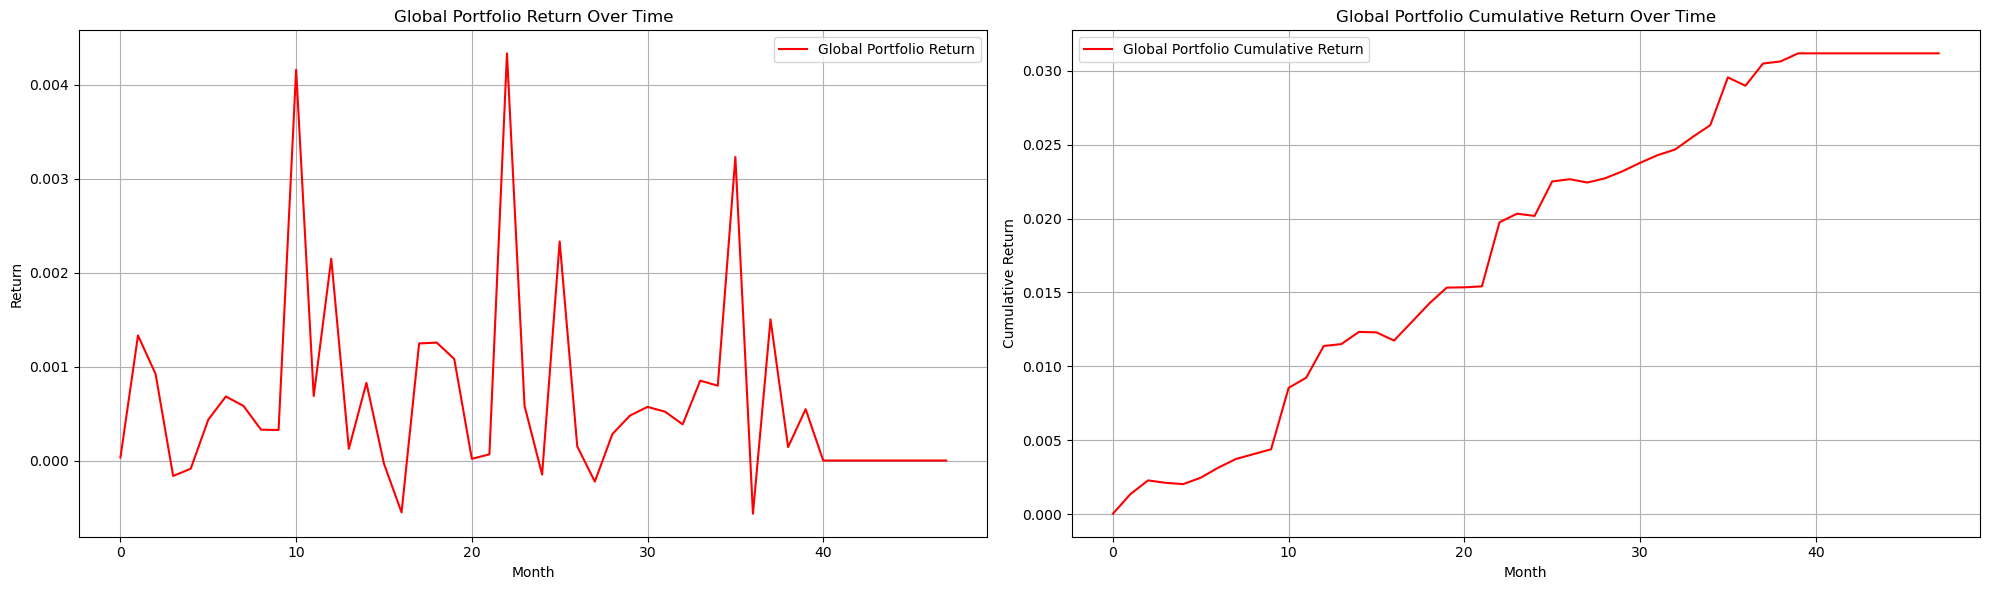

,Volatility,Average Return,Sharpe Ratio,Max Drawdown
0,0.003634,0.007795,2.145166,-0.000586


In [32]:
st = strat_setup1[0][0]
lg = strat_setup1[0][1]
length_start_oos = length_estimation_window[0]

ptf_return = get_global_perf(st, lg, index_start_oos,length_start_oos,RETURNS, clusters, N_CLUSTER, month_st)
plot_performance(ptf_return)
metrics = get_risk_metrics(ptf_return)

metrics

### Strategie 1.2

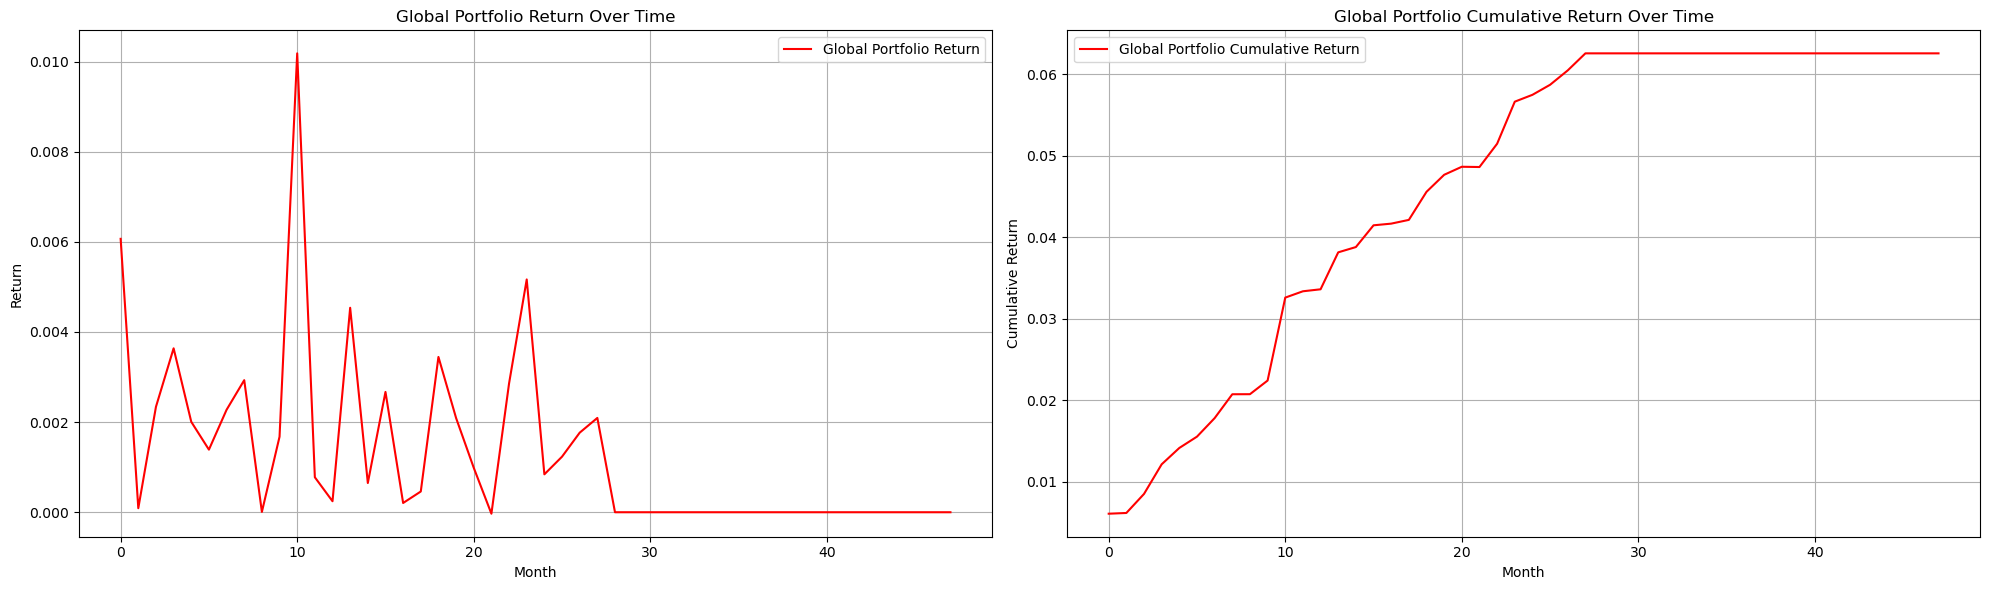

,Volatility,Average Return,Sharpe Ratio,Max Drawdown
0,0.006983,0.015648,2.240732,-0.000033


In [22]:
st = strat_setup1[1][0]
lg = strat_setup1[1][1]
length_start_oos = length_estimation_window[1]

ptf_return = get_global_perf(st, lg, index_start_oos,length_start_oos,RETURNS, clusters, N_CLUSTER, month_st)
plot_performance(ptf_return)
metrics = get_risk_metrics(ptf_return)

metrics

### Strategie 1.3

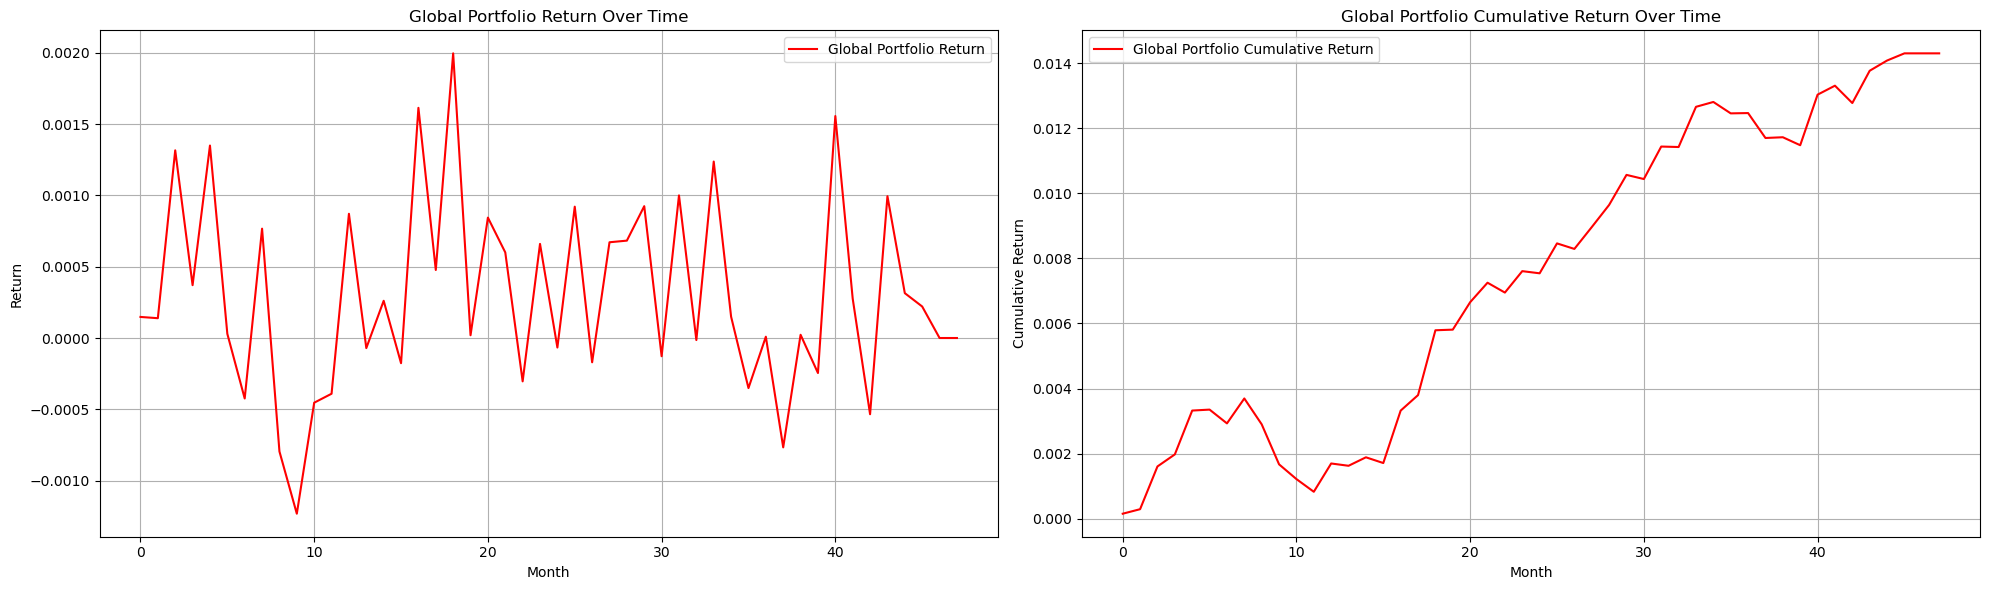

,Volatility,Average Return,Sharpe Ratio,Max Drawdown
0,0.002366,0.003578,1.512502,-0.002868


In [23]:
st = strat_setup1[2][0]
lg = strat_setup1[2][1]
length_start_oos = length_estimation_window[2]

ptf_return = get_global_perf(st, lg, index_start_oos,length_start_oos,RETURNS, clusters, N_CLUSTER, month_st)
plot_performance(ptf_return)
metrics = get_risk_metrics(ptf_return)

metrics

### Strategie 2.1

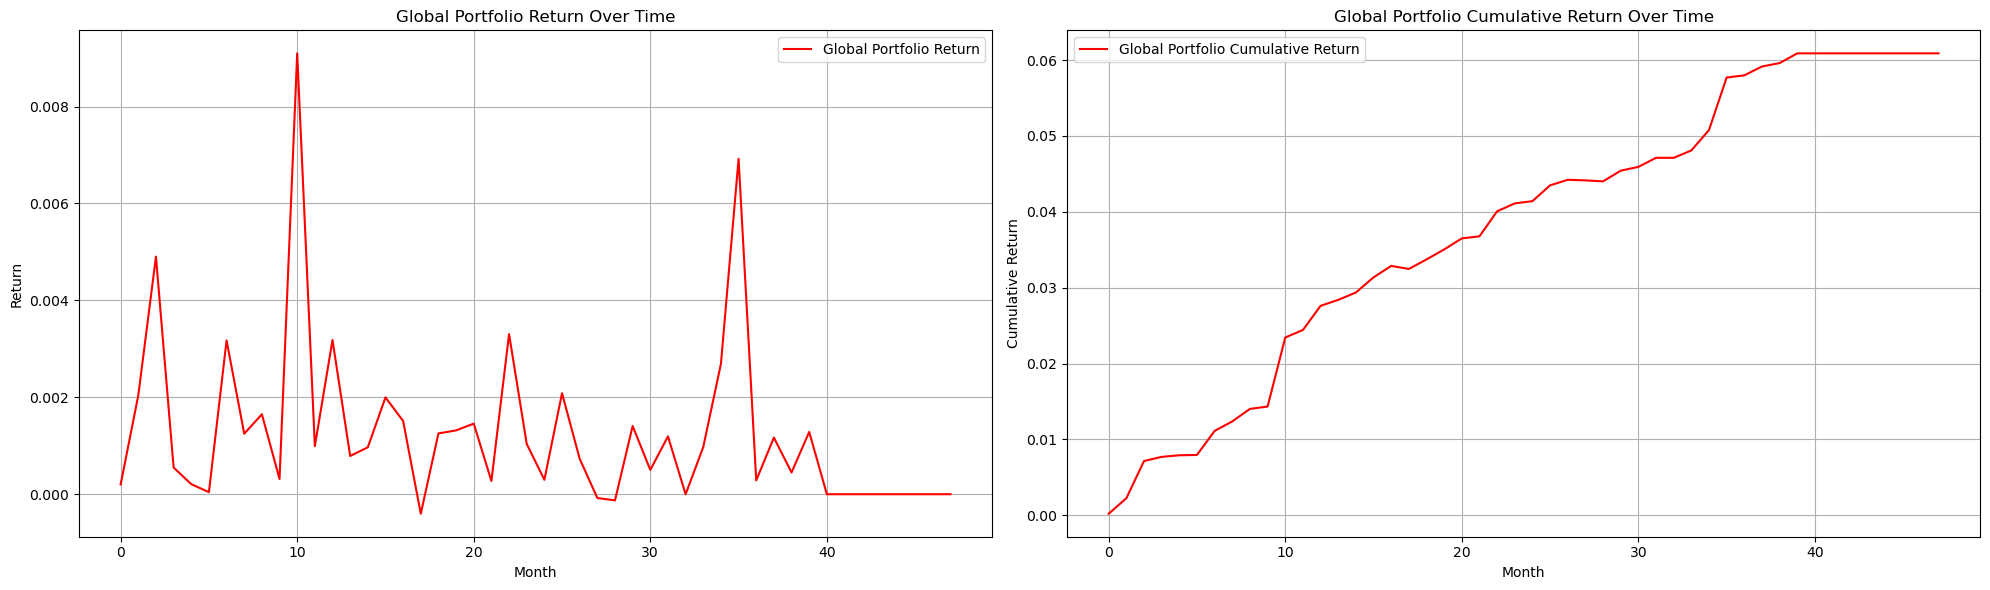

,Volatility,Average Return,Sharpe Ratio,Max Drawdown
0,0.006254,0.015222,2.433781,-0.000402


In [24]:
st = strat_setup2[0][0]
lg = strat_setup2[0][1]
length_start_oos = length_estimation_window[0]

ptf_return = get_global_perf(st, lg, index_start_oos,length_start_oos,RETURNS, clusters, N_CLUSTER, month_st)
plot_performance(ptf_return)
metrics = get_risk_metrics(ptf_return)

metrics

### Strategie 2.2

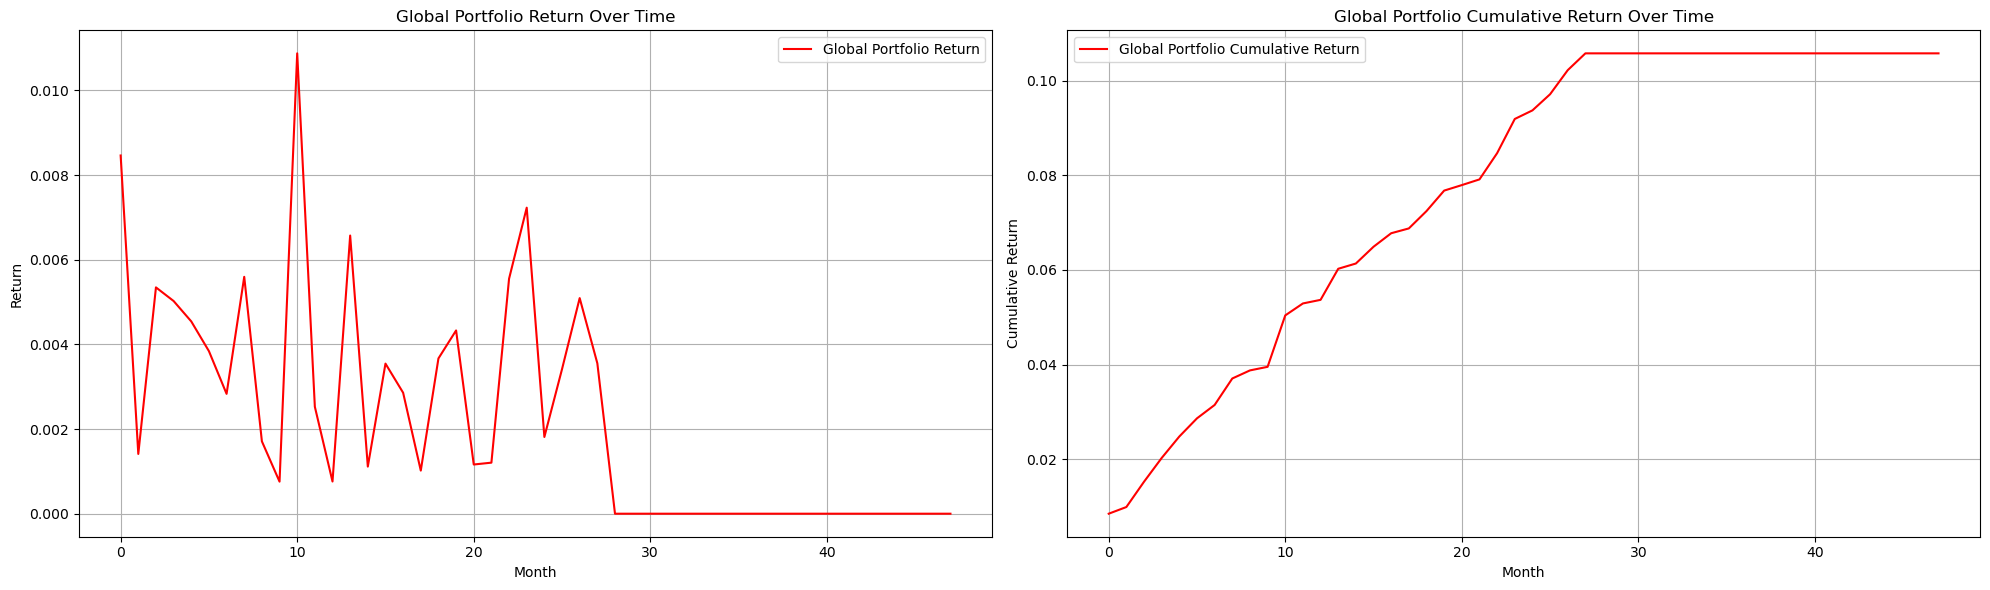

,Volatility,Average Return,Sharpe Ratio,Max Drawdown
0,0.009254,0.026452,2.858499,0.0


In [25]:
st = strat_setup2[1][0]
lg = strat_setup2[1][1]
length_start_oos = length_estimation_window[1]

ptf_return = get_global_perf(st, lg, index_start_oos,length_start_oos,RETURNS, clusters, N_CLUSTER, month_st)
plot_performance(ptf_return)
metrics = get_risk_metrics(ptf_return)

metrics

### Strategie 2.3

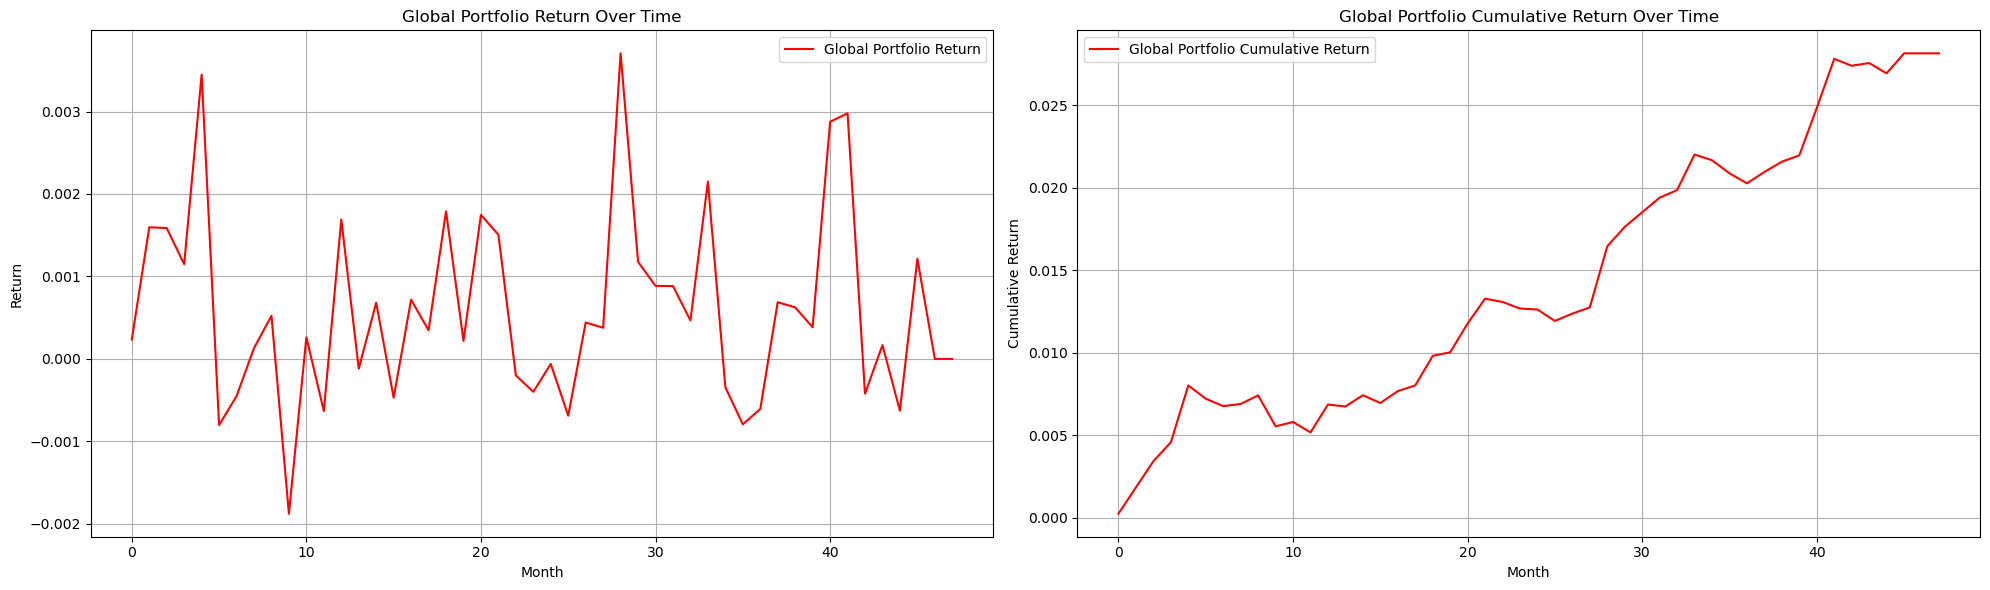

,Volatility,Average Return,Sharpe Ratio,Max Drawdown
0,0.004029,0.007039,1.747016,-0.002846


In [26]:
st = strat_setup2[2][0]
lg = strat_setup2[2][1]
length_start_oos = length_estimation_window[2]

ptf_return = get_global_perf(st, lg, index_start_oos,length_start_oos,RETURNS, clusters, N_CLUSTER, month_st)
plot_performance(ptf_return)
metrics = get_risk_metrics(ptf_return)

metrics